In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/Clustering/K-Means

/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means


In [ ]:
# %cd '/content'

/content


In [ ]:
import os
import shutil
import numpy as np
from glob import glob
import logging
from PIL import Image
import matplotlib.pyplot as plt
import skimage.segmentation as segmentation
import h5py
import cv2
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
#from torchsummary import summary
import time
import torch
from torch.nn.functional import normalize

In [ ]:
dsDir = '/content/Dataset'

concept_dir = dsDir + '/concepts'
concept_dir_cache = dsDir + '/concepts_embeddings'

base_dir_imgs = dsDir + '/orginal_images'
base_dir_imgs_cache = dsDir + '/orginal_images_cache'


In [ ]:
#load Data
!cp  '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/15_classes_embeddings_02_03_2022.tar' '/content'
!tar --extract --file '/content/15_classes_embeddings_02_03_2022.tar' 

In [ ]:
cluster_fileName = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/concepts_clusters.h5'

with h5py.File(cluster_fileName, 'r') as f:
  concept_imgs = f['concept_img'][()]#f['superpixels'].value
  concept_embdd = f['concept_embedding'][()]#f['norm_feat'].value

concept_embdd_ext = np.expand_dims(concept_embdd,axis=0)
print(concept_embdd_ext.shape)

(1, 150, 512)


In [ ]:
# test_img = ['Black_Footed_Albatross_0001_796111.hdf5',
# 'Brewer_Blackbird_0002_2278.hdf5',
# 'Painted_Bunting_0001_16585.hdf5']

In [ ]:
# for i in range(3):
#   with h5py.File(os.path.join(base_dir_imgs_cache, str(i), test_img[i]), 'r') as f:
#     print('\n\n\n\n Image', i)
#     plt.imshow(cv2.imread(os.path.splitext(os.path.join(base_dir_imgs,str(i),test_img[i]))[0]+'.jpg'))
#     plt.show()
#     sp = f['superpixels'][()]#f['superpixels'].value
#     norm_feat = f['norm_feat'][()]#f['norm_feat'].value
  
#     for embedding_i,img_sp in zip(norm_feat,sp):
#       plt.imshow(img_sp)
#       plt.show()

In [ ]:
class readMultiClass_DataSet(Dataset):
  def __init__(self, image_dir, image_dir_cache, target_size, classses_to_use = None, targetClassId = None):
    self.image_dir = image_dir
    self.image_dir_cache = image_dir_cache
    self.target_size = target_size

    self.class_name = [x for x in sorted(os.listdir(image_dir)) if not x.startswith('.')]
    self.class_idx = [int(x) for x in self.class_name]

    if targetClassId != None:
      if targetClassId in self.class_idx:
        self.class_name, self.class_idx = [x for x in sorted(os.listdir(image_dir)) if not x.startswith('.') if int(x)==targetClassId], [targetClassId]
      else:
        print('Invalid Class Id Provided in main DS')
        self.class_name = None
        self.class_idx = None
      print('Selected Class: ',self.class_name)
      
    elif classses_to_use != None:
      self.class_name, self.class_idx = self.class_name[0:classses_to_use], self.class_idx[0:classses_to_use]

    self.imgs_path = []
    if self.class_idx != None and len(self.class_idx)>= 0:
      for class_path in self.class_name:
        self.imgs_path.extend([os.path.join(class_path, os.path.splitext(x)[0]) for x in sorted(os.listdir(os.path.join(image_dir, class_path)))])#[0:100])
        # self.imgs_path.extend([os.path.join(class_path, os.path.splitext(x)[0]) for x in os.listdir(os.path.join(image_dir, class_path))])
      print(f'Dataset Founded with {len(self.class_name)} class and {len(self.imgs_path)} input Images')
    else:
      print(f'Dataset Founded with 0 class and 0 input Images')
    
    # self.norm_feat = []
    # for pth_ind in range(len(self.imgs_path)):
    #   self.norm_feat.append(model.extract_feat(glob(os.path.join(self.image_dir, self.imgs_path[pth_ind]+'*'))[0]))
    #   print('\rCalculating Embeddings', pth_ind+1, end='')

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, i):
    img = np.asarray(Image.open(glob(os.path.join(self.image_dir, self.imgs_path[i]+'*'))[0]).convert('RGB').resize(self.target_size))
    path = os.path.join(self.image_dir, self.imgs_path[i])
    img_class = int(self.imgs_path[i].split('/')[0])
    #print(img_class, self.imgs_path[i], 'class id')

    with h5py.File(os.path.join(glob(os.path.join(self.image_dir_cache, self.imgs_path[i]+'*'))[0]), 'r') as f:
      sp = f['superpixels'][()]#f['superpixels'].value
      norm_feat = f['norm_feat'][()]#f['norm_feat'].value
      #norm_feat = (norm_feat - np.min(norm_feat))/(np.max(norm_feat) - np.min(norm_feat))

    imgs_names, imgs_num, sp_label = [], [], []
    
    for s in sp:
      imgs_names.append(self.imgs_path[i])
      imgs_num.append(i)
      sp_label.append(img_class)
    
    return {'image': img/255, 'sp': sp, 'imgs_names': imgs_names, 'imgs_num': imgs_num, 'sp_label':sp_label, 'img_class': img_class, 'norm_feat':norm_feat,'image_path':path}
    

base_dir_msks = None

dataset = readMultiClass_DataSet(base_dir_imgs, base_dir_imgs_cache, (256, 256))

test_size = 40
dataset, dataset_test =  random_split(dataset, [len(dataset)-test_size, test_size], generator=torch.Generator().manual_seed(42))

for batch in dataset_test:
  print(batch['img_class'])
  # print(batch["sp_label"])
  # print(batch["image"])
  # print(batch["norm_feat"])
  break;
classes_to_use= 15

Dataset Founded with 15 class and 891 input Images
1


### **Transform Dataset**

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(30),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [ ]:
classes_to_use= 15

In [ ]:

from torch._C import dtype
from numpy.core.fromnumeric import shape

torch.cuda.empty_cache() # P

class CNN(nn.Module):

    def __init__(self):
      super(CNN,self).__init__()
    
      self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5,stride=1, padding=2)
      self.batchnorm1 = nn.BatchNorm2d(32)        #Batch normalization
      self.relu = nn.ReLU()                 #RELU Activation
      self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 64/2 = 32
    
      self.cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5,stride=1, padding=2)
      self.batchnorm2 = nn.BatchNorm2d(32)        #Batch normalization
      self.relu = nn.ReLU()                 #RELU Activation
      self.maxpool2 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 64/2 = 32

      self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.batchnorm3 = nn.BatchNorm2d(16)
      self.relu = nn.ReLU()                 #RELU Activation
      self.maxpool3 = nn.MaxPool2d(kernel_size=2)    #Size now is 32/2 = 16

      self.cnn4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.batchnorm4 = nn.BatchNorm2d(16)
      self.relu = nn.ReLU()                 #RELU Activation
      self.maxpool4 = nn.MaxPool2d(kernel_size=2)    #Size now is 32/2 = 16

      #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
      self.fc1 = nn.Linear(in_features=4096, out_features=512)   #Flattened image is fed into linear NN and reduced to half size
      self.droput = nn.Dropout(p=0.5)                    #Dropout used to reduce overfitting
      self.fc2 = nn.Linear(in_features=512, out_features=50)
      self.droput = nn.Dropout(p=0.5)
      self.fc3 = nn.Linear(in_features=50, out_features=classes_to_use)    #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
    
      
    def forward(self,x, queryimg, centers):
      out = self.cnn1(x)
      out = self.batchnorm1(out)
      out = self.relu(out)
      out = self.maxpool1(out)
      out = self.cnn2(out)
      out = self.batchnorm2(out)
      out = self.relu(out)
      out = self.maxpool2(out)
      out = self.cnn3(out)
      out = self.batchnorm3(out)
      out = self.relu(out)
      out = self.maxpool3(out)
      out = self.cnn4(out)
      out = self.batchnorm4(out)
      out = self.relu(out)
      out = self.maxpool4(out)

      # print(out.shape)
      #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
      out = out.reshape(-1,4096)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
      #Then we forward through our fully connected layer 
      out = self.fc1(out)
      out = self.relu(out)
      out = self.droput(out)
      # print(out.shape)

      # print(queryimg.shape)
      # print(torch.t(centers).shape)
      a_score = torch.matmul(queryimg, torch.t(centers))
      # print(a_score)
      final = torch.matmul(a_score, centers)
      final = torch.mean(final,0)
      final = torch.mean(final,0)
      final = torch.unsqueeze(final, dim=0)
      final = torch.add(final, out)
      # print(final.shape)
      # print('Final concat')

      out = self.fc2(out)
      # out = self.fc2(final)
      out = self.relu(out)
      out = self.droput(out)
      out = self.fc3(out)
      # print('Final out layer {}'.format(out.shape))
      # print("Out shape", out.shape)
      # out = torch.squeeze(out)
      # print("Out shape", out.shape)
      return out, a_score

net = CNN()



In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
net.to(device)

CNN(
  (cnn1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2d(

In [ ]:
imgs = torch.from_numpy(np.ones((1, 3, 256, 256)).astype('float32'))
imgs.to(device)

inputs_img_embeddings = torch.from_numpy(np.ones((1, 8, 512)).astype('float32'))
inputs_img_embeddings.to(device)

# concept_centers = torch.from_numpy(np.ones((10, 512)).astype('float32'))
concept_centers = torch.from_numpy(np.array(concept_embdd))
concept_centers.to(device)

with torch.no_grad():
  network_output, attention_score = net(imgs, inputs_img_embeddings, concept_centers)
  print('net output: ',network_output.shape)

# print(attention_score[0])

net output:  torch.Size([1, 15])


In [ ]:
print(attention_score[7])

tensor([512., 512., 512., 512., 512., 512., 512., 512., 512., 512.])


In [ ]:
class processing_time:
    def __init__(self):
      self._start_time = time.time()
      self.last_times = []
      self.last_run_time = time.time()
    
    def tic(self):
        #global _start_time 
        self._start_time = time.time()
    
    def tac(self):
        t_sec = round(time.time() - self._start_time)
        (t_min, t_sec) = divmod(t_sec,60)
        (t_hour,t_min) = divmod(t_min,60) 
        #return 'Elapsed Time: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec)
        return 'Elapsed Time: {}:{}:{}'.format(t_hour,t_min,t_sec)

    def tac_remianing_time(self, indx, total_indx):
        t_sec = round(time.time() - self._start_time)
        (t_min, t_sec) = divmod(t_sec,60)
        (t_hour,t_min) = divmod(t_min,60) 
        
        ##calucalte remaning time
        self.last_times.append(round(time.time() - self.last_run_time))
        
        len_last_t = len(self.last_times)
        if len_last_t > 50:
            self.last_times.pop(0)
        mean_t = sum(self.last_times) // len_last_t
        remain_s_tot = mean_t * (total_indx - indx - 1)
        #remain_s_tot = mean_t * total_indx / indx
        
        (r_min, r_sec) = divmod(remain_s_tot,60)
        (r_hour,r_min) = divmod(r_min,60)

        return 'Elapsed Time: {}:{}:{}  ETA: {}:{}:{}'.format(t_hour,t_min,t_sec, int(r_hour),int(r_min),int(r_sec))

    def recordLastProcessingTime(self):
      self.last_run_time = time.time()

# classid = -100


In [ ]:
def train_network(network,
                  device, 
                  dataset,
                  epochs = 20,
                  batch_size =25, 
                  learning_rate=0.0001, 
                  test_per=0.1, 
                  val_test_per=0.05, 
                  save_dir = 'history', 
                  img_target_size = (256, 256), 
                  restore_training = False,
                  ):
  # network.returnAttenton = False
  #device2 = 'cpu'
  #unet.to(device2)
  run_num = 0
  num_train = len(dataset)
  print('Dataset size {}'.format(num_train))
  train_ds_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  p_time = processing_time()
  train_loss , train_accuracy = [], []

  for epoch in range(run_num, epochs, 1):
    network.train()
    network.returnAttenton = False
    p_time.tic()

    subepoch = 0
    epoch_loss = 0
    epoch_acc = 0
    n_loss = 0
    img_step = 0
    for batch in train_ds_loader:
      #print(batch['img_class'])
      # print(batch["norm_feat"].shape)
      clss, norm_image, image_embeddings = batch['img_class'], batch["image"], batch["norm_feat"]
      n_imgs = torch.Tensor(np.asarray(norm_image)).reshape(-1,256,256,3).to(device).permute((0,3,1,2)).float()
      n_imgs_embd = torch.Tensor(np.asarray(image_embeddings)).to(device).float()
      # print(n_imgs_embd.shape)
      # centers = np.zeros((150,512))
      # concept_centers = torch.tensor(centers).to(device).float()
      

      pred, attention_score  = network(n_imgs, n_imgs_embd,concept_centers)
      concept_class = np.asarray([clss])#np.asarray(concept_batch['class_id'])
      class_label = torch.Tensor(concept_class).to(device).long()

      loss = criterion(pred, class_label)#concept_class)
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_value_(network.parameters(), 0.1)
      optimizer.step()
      epoch_loss = epoch_loss+loss.item()
      n_loss = n_loss+1
      pred = torch.argmax(pred, dim=1)
      acc = ((pred == class_label).sum().item())/len(pred)
      epoch_acc += acc
      print('\rEpoch : {}/{} || SubEpoch : {}/{} || Accuracy : {} || Loss : {:.5f} || Pred Class : {} || Actual class : {} || {}'
               .format( ((epoch+1)),epochs,n_loss, num_train, acc,loss.item() , pred.item() , concept_class.item()  ,p_time.tac_remianing_time(subepoch, num_train)), end=' ')
    print('\n\t\tEpoch : {}/{} || Epoch Loss : {} || Epoch Accuracy : {}  || {}'.format( (epoch+1),epochs,(epoch_loss/n_loss), epoch_acc/n_loss, p_time.tac()))
    train_loss.append(epoch_loss/n_loss)
    train_accuracy.append(epoch_acc/n_loss)
    torch.save(network.state_dict(), os.path.join(save_dir, f'softNet_model_{epoch+1}.pt'))
  
  # accuracy plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_accuracy, color='green', label='Training Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(os.path.join(save_dir, 'initial_training_accuracy.png'))
  # plt.savefig('../outputs/initial_training_accuracy.png')
  plt.show()
  
  # loss plots
  plt.figure(figsize=(10, 7))
  plt.plot(train_loss, color='orange', label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  # plt.savefig('../outputs/initial_training_loss.png')
  plt.savefig(os.path.join(save_dir, 'initial_training_loss.png'))
  plt.show()

Dataset size 851


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Epoch : 1/20 || SubEpoch : 851/851 || Accuracy : 0.0 || Loss : 3.14291 || Pred Class : 0 || Actual class : 1 || Elapsed Time: 0:2:39  ETA: 35:39:10 
		Epoch : 1/20 || Epoch Loss : 2.7337937136514485 || Epoch Accuracy : 0.0846063454759107  || Elapsed Time: 0:2:39
Epoch : 2/20 || SubEpoch : 851/851 || Accuracy : 0.0 || Loss : 2.69636 || Pred Class : 14 || Actual class : 9 || Elapsed Time: 0:2:39  ETA: 72:29:10 
		Epoch : 2/20 || Epoch Loss : 2.6486007367752133 || Epoch Accuracy : 0.136310223266745  || Elapsed Time: 0:2:39
Epoch : 3/20 || SubEpoch : 851/851 || Accuracy : 0.0 || Loss : 2.40573 || Pred Class : 11 || Actual class : 6 || Elapsed Time: 0:2:50  ETA: 111:40:50 
		Epoch : 3/20 || Epoch Loss : 2.5223904261858006 || Epoch Accuracy : 0.16216216216216217  || Elapsed Time: 0:2:50
Epoch : 4/20 || SubEpoch : 851/851 || Accuracy : 1.0 || Loss : 1.48661 || Pred Class : 11 || Actual class : 11 || Elapsed Time: 0:2:40  ETA: 148:45:0 
		Epoch : 4/20 || Epoch Loss : 2.309768111562109 || Epoch

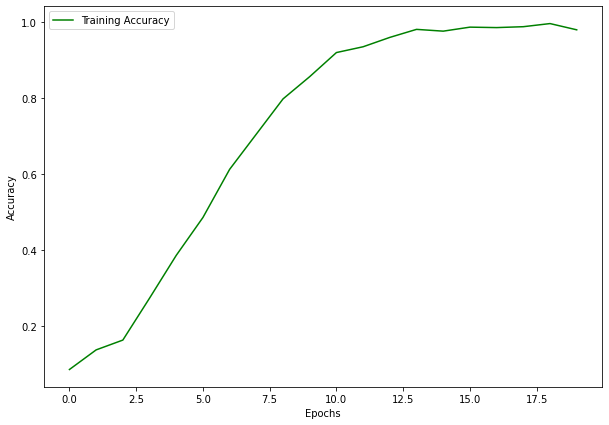

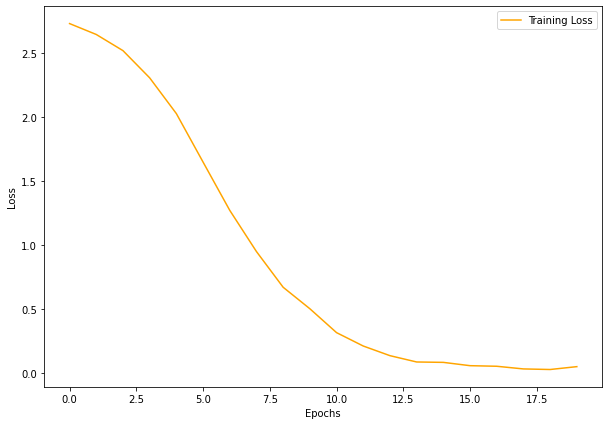

In [ ]:
torch.cuda.empty_cache() # P
save_dir_path='/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/exp_2'
os.makedirs(save_dir_path)
train_network(net, device, dataset, epochs=20, batch_size=16, save_dir=save_dir_path)

In [ ]:

def test_network(network,
                  device, 
                  dataset,
                  epochs = 20,
                  batch_size = 8, 
                  learning_rate=0.0001, 
                  test_per=0.1, 
                  val_test_per=0.05, 
                  save_dir = 'history', 
                  img_target_size = (256, 256), 
                  restore_training = False,
                  ):
  
  network.returnAttenton = False
  run_num = 0
  num_train = len(dataset)
  test_ds_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  p_time = processing_time()
  with torch.no_grad():
    for epoch in range(run_num, epochs, 1):
      network.eval()
      network.returnAttenton = False
      p_time.tic()

      subepoch = 0
      epoch_loss = 0
      epoch_acc = 0
      n_loss = 0
      img_step = 0
      print('start traning')
      for batch in test_ds_loader:
        img_class, norm_image, image_embeddings = batch['img_class'], batch["image"], batch["norm_feat"]
        n_imgs = torch.Tensor(np.asarray(norm_image)).reshape(-1,256,256,3).to(device).permute((0,3,1,2)).float()
        n_imgs_embd = torch.Tensor(np.asarray(image_embeddings)).to(device).float()
        subepoch = subepoch+1

        pred, attention_score = network(n_imgs, n_imgs_embd,concept_centers)
        # print('Prediction : {}'.format(pred))
        loss = criterion(pred, img_class)#concept_class)
        #print(concept_class)

        optimizer.zero_grad()
        #loss.backward()
        nn.utils.clip_grad_value_(network.parameters(), 0.1)
        #optimizer.step()
        epoch_loss = epoch_loss+loss.item()
        n_loss = n_loss + 1
        pred = torch.argmax(pred, dim=1)
        acc = ((pred == img_class).sum().item())/len(pred)
        epoch_acc += acc
        print('\rEpoch : {}/{} || SubEpoch : {}/{} || Accuracy : {} || Loss : {:.5f} || Pred Class : {} || Actual class : {} || Time remaining : {}'
            .format( ((epoch+1)),epochs,subepoch, num_train, acc,loss.item() , pred.item() , img_class.item()  ,p_time.tac_remianing_time(subepoch, num_train)), end='')
  print('\n\t\tEpoch : {}/{} || Epoch Loss : {} || Epoch Accuracy : {}  || Time : {}'.format( (epoch+1),epochs,(epoch_loss/n_loss), epoch_acc/n_loss, p_time.tac()))

In [ ]:
save_dir_path='/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/exp_2'
net.load_state_dict(torch.load(os.path.join(save_dir_path, 'softNet_model_'+str(5)+'.pt')))
test_network(net, device, dataset_test, epochs=1, batch_size=1, save_dir='/content/')

start traning
Epoch : 1/1 || SubEpoch : 40/40 || Accuracy : 1.0 || Loss : 0.03744 || Pred Class : 2 || Actual class : 2 || Time remaining : Elapsed Time: 0:0:4  ETA: -1:59:58
		Epoch : 1/1 || Epoch Loss : 2.392636401997879 || Epoch Accuracy : 0.275  || Time : Elapsed Time: 0:0:4


## **Training Method**

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  
  for (x, y) in iterator:
      
      x = x.to(device)
      y = y.to(device)
      
      optimizer.zero_grad()
              
      y_pred, _ = model(x)
      
      loss = criterion(y_pred, y)
      
      # acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
      
      loss.backward()
      optimizer.step()
      scheduler.step()
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
      
  epoch_loss /= len(iterator)
  epoch_acc /= len(iterator)
      
  return epoch_loss, epoch_acc

## **Evaluate Method**

In [ ]:
def evaluate(model, iterator, criterion, device):
    
  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  with torch.no_grad():
      
      for (x, y) in iterator:

          x = x.to(device)
          y = y.to(device)

          y_pred, _ = model(x)

          loss = criterion(y_pred, y)

          # acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

          epoch_loss += loss.item()
          epoch_acc += acc.item()

      
  epoch_loss /= len(iterator)
  epoch_acc /= len(iterator)

  return epoch_loss, epoch_acc

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

## **Training and Evaluating our Model**

In [ ]:
best_valid_loss = float('inf')
EPOCHS = 30

for epoch in range(EPOCHS):
  start_time = time.monotonic()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
      
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'cub_best_model.pt')
      print('saved at epoch # {}'.format(epoch+1))

  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
  print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')